In [2]:
%pylab inline
import numpy as np
import scipy.stats as spstats
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
out_dirs = [
    "archive/2017-07-28 20:49:42 cd433b1",
    "archive/2017-07-30 09:27:01 cd433b1",
    "archive/2017-08-02 22:26:36 cd433b1",
    "archive/2017-08-04 00:49:20 cd433b1"
]
out_dirs = [
    "output/2017-08-05 08:02:18 cd433b1"
]

In [53]:
df_runs = pd.concat([pd.DataFrame.from_csv("%s/runs.csv" % d) for d in out_dirs])
df_values = pd.concat([pd.DataFrame.from_csv("%s/values.csv" % d) for d in out_dirs])
rs = sorted(set((df_values["rewire"] * 6).round() / 6.0))
strategies = ["best", "loc_best", "conform", "loc_conform", "loc_cons"]
trials = sorted(set(df_values["trial"]))
steps = sorted(set(df_values["step"]))

In [48]:
trials[:1]

['1501934538-0']

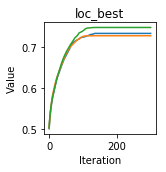

In [60]:
plt.figure(figsize=(1*15.0/6.0,1*15.0/6.0))
for i, r in enumerate([0.5]): #enumerate(rs):
    df_rewire = df_values[df_values["rewire"] == r]
    for j, strategy in enumerate(["loc_best"]): #enumerate(strategies):
        df_strategy = df_rewire[df_rewire["strategy"] == strategy]
        #plt.subplot(len(rs),len(strategies),1+j+i*len(strategies))
        plt.title(strategy)
        plt.ylabel("Rewire = %0.2f" % r)
        for trial_n in sorted(set(df_strategy["trial"]))[:3]:
            df_trial = df_strategy[df_strategy["trial"] == trial_n]
            plot(df_trial["step"], df_trial["value"])
            xlabel("Iteration")
            ylabel("Value")
plt.tight_layout()
plt.savefig("fig-trials.png", format="png", dpi=300)

In [5]:
def values_to_efficiency(values):
    max_delta = [max(values) - values[i] for i in range(len(values))]
    nonpositive = [i for i, d in enumerate(max_delta) if d <= 0.0001]
    return 1.0 / float(nonpositive[0])

def values_to_converge(values):
    max_delta = [max(values) - values[i] for i in range(len(values))]
    nonpositive = [i for i, d in enumerate(max_delta) if d <= 0.0001]
    return nonpositive[0]    

In [61]:
d_trial = []
d_strat = []
d_eff = []
d_perf = []
d_rewire = []
d_degree = []
d_converge = []
for i, trial in enumerate(sorted(set(df_values["trial"]))):
    for j, strategy in enumerate(strategies):
        df_strat = df_values[df_values["strategy"] == strategy]
        df = df_strat[df_strat["trial"] == trial]
        eff = values_to_efficiency(list(df["value"]))
        d_converge.append(values_to_converge(list(df["value"])))
        d_trial.append(trial)
        d_strat.append(strategy)
        d_eff.append(eff)
        d_rewire.append(df_runs["rewire"][trial])
        d_degree.append(df_runs["degree"][trial])
        d_perf.append(df_runs["%s_perf" % strategy][trial])
df_eff = pd.DataFrame({
    "trial": d_trial,
    "rewire": d_rewire,
    "degree": d_degree,
    "strategy": d_strat,
    "eff": d_eff,
    "perf": d_perf,
    "converge": d_converge
})

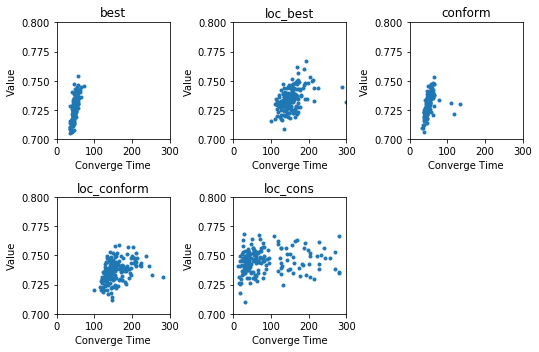

In [36]:
plt.figure(figsize=(3*15.0/6.0,2*15.0/6.0))
for i, strategy in enumerate(strategies):
    plt.subplot(2,3, i+1)
    plt.title(strategy)
    df = df_eff[df_eff["strategy"] == strategy]
    plot(df["converge"], df["perf"], '.')
    xlabel('Converge Time')
    ylabel('Value')
    xlim([0, 300])
    ylim([0.7, 0.8])
plt.tight_layout()
plt.savefig("fig-converge-value.png", format="png", dpi=300)

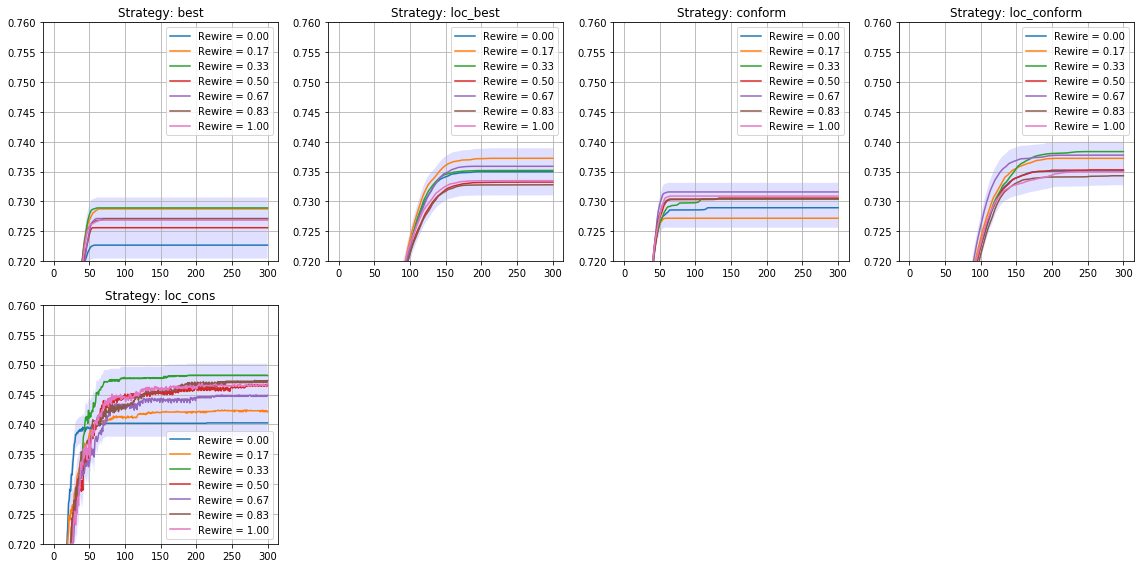

In [7]:
plt.figure(figsize=(4*4,4*2))
for j, strategy in enumerate(strategies):
    df_strategy = df_values[df_values["strategy"] == strategy]
    plt.subplot(2,4,1+j)
    plt.title("Strategy: %s" % strategy)
    for i, r in enumerate(rs):
        df_rewire = df_strategy[(df_strategy["rewire"] - r).abs() < 0.01]
        label = "Rewire = %0.2f" % r
        step_mean = []
        step_se = []
        for step in sorted(set(df_rewire["step"])):
            df = df_rewire[df_rewire["step"] == step]
            step_mean.append(df["value"].mean())
            s = df["value"].std(ddof=1)
            step_se.append(s / sqrt(len(df["value"])))
        mean = np.array(step_mean)
        se = np.array(step_se)
        plt.fill_between(range(len(step_mean)), mean - se, mean + se, facecolor="#dfdfff")
        plt.plot(step_mean, label=label)
    plt.legend()
    plt.grid()
    plt.ylim([0.5, 0.8])
    plt.ylim([0.72, 0.76])
plt.tight_layout()

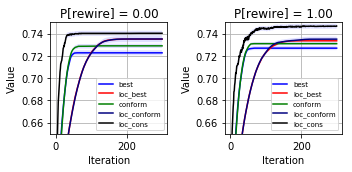

In [29]:
colors = ["#0000FF", "#FF0000", "#007F00", "#00007F", "#000000"]
plt.figure(figsize=(15.0/3.0,7.5/3.0))
for i, r in enumerate([0, 1]):
    df_rewire = df_values[(df_values["rewire"] - r).abs() < 0.01]
    plt.subplot(1,2,1+i)
    plt.title("P[rewire] = %0.2f" % r)
    for j, strategy in enumerate(strategies):
        df_strategy = df_rewire[df_rewire["strategy"] == strategy]
        label = strategy
        step_mean = []
        step_se = []
        for step in sorted(set(df_strategy["step"])):
            df = df_strategy[df_strategy["step"] == step]
            step_mean.append(df["value"].mean())
            s = df["value"].std(ddof=1)
            step_se.append(s / sqrt(len(df["value"])))
        mean = np.array(step_mean)
        se = np.array(step_se)
        plt.fill_between(range(len(step_mean)), mean - se, mean + se, facecolor="#dfdfff")
        plt.plot(step_mean, label=label, color=colors[j])
        xlabel("Iteration")
        ylabel("Value")
    plt.grid()
    plt.legend(fontsize=7)
    plt.ylim([0.5, 0.8])
    plt.ylim([0.65, 0.75])
plt.tight_layout()
plt.savefig("fig-val-iter.pdf", format="pdf")
plt.savefig("fig-val-iter.png", format="png", dpi=300)

In [ ]:
df_runs.head()

In [31]:
def estimate_curve(data_x, data_y, points, window):
    h = max(data_x)
    l = min(data_x)
    step = (h-l)/float(points - 1)
    curve_x = np.arange(points) * step + l
    curve_y = np.ones(points)
    for j, x in enumerate(curve_x):
        total = 0.0
        norm = 0.0
        for i, dx in enumerate(data_x):
            dy = data_y[i]
            total += dy * np.exp(-1 * np.power(x - dx, 2) / (2.0*window))
            norm += np.exp(-1 * np.power(x - dx, 2) / (2.0*window))
        curve_y[j] = total / norm
    return curve_x, curve_y

def line_points(m, b, x):
    x0 = min(x)
    x1 = max(x)
    y0 = m*x0 + b
    y1 = m*x1 + b
    return [x0,x1], [y0,y1]

best r=0.08 p=0.2699 m=0.000087, b=0.715198
loc_best r=-0.08 p=0.2976 m=-0.000083, b=0.745687
conform r=0.13 p=0.0895 m=0.000120, b=0.714134
loc_conform r=-0.02 p=0.7934 m=-0.000020, b=0.738797
loc_cons r=0.22 p=0.0043 m=0.000238, b=0.713698


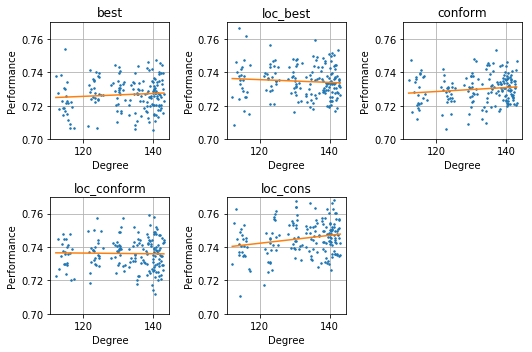

In [33]:
plt.figure(figsize=(3.0*15.0/6.0,2*15.0/6.0))
for j, strategy in enumerate(strategies):
    plt.subplot(2,3,1+j)
    r,p = spstats.pearsonr(df_runs["degree"], df_runs["%s_perf" % strategy])
    plt.plot(df_runs["degree"], df_runs["%s_perf" % strategy], '.', markersize=3)
    m, b = np.polyfit(df_runs["degree"], df_runs["%s_perf" % strategy], 1)
    #x, y = estimate_curve(df_runs["degree"], df_runs["%s_perf" % strategy], 100, 5)
    x, y = line_points(m,b,df_runs["degree"])
    plt.plot(x, y, '-')
    plt.title(strategy)
    print "%s r=%0.2f p=%0.4f m=%f, b=%f" % (strategy, r, p, m, b)
    xlabel("Degree")
    ylabel("Performance")
    plt.grid()
    plt.ylim([0.7, 0.77])
plt.tight_layout()
plt.savefig("fig-deg-perf.pdf", format="pdf")
plt.savefig("fig-deg-perf.png", format="png", dpi=300)

best r=0.05 p=0.4758
loc_best r=-0.09 p=0.2199
conform r=0.11 p=0.1450
loc_conform r=-0.05 p=0.4757
loc_cons r=0.18 p=0.0150


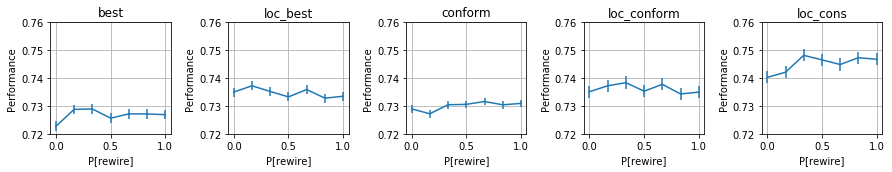

In [48]:
plt.figure(figsize=(5.0*15.0/6.0,15.0/6.0))
for j, strategy in enumerate(strategies):
    plt.subplot(1,5,1+j)
    r,p = spstats.pearsonr(df_runs["rewire"], df_runs["%s_perf" % strategy])
    mean = []
    serr = []
    std = []
    for rw in rs:
        df = df_runs[(df_runs["rewire"] - rw).abs() < 0.01]
        m = df["%s_perf" % strategy].mean()
        s = df["%s_perf" % strategy].std(ddof=1)
        se = s / sqrt(float(len(df["%s_perf" % strategy])))
        mean.append(m)
        serr.append(se)
        std.append(s)
    plt.errorbar(rs, mean, yerr=se)
    plt.title(strategy)
    print "%s r=%0.2f p=%0.4f" % (strategy, r, p)
    xlabel("P[rewire]")
    ylabel("Performance")
    plt.legend()
    plt.grid()
    plt.ylim([0.72, 0.76])
plt.tight_layout()

best r=-0.06 p=0.4044 m=-0.000019, b=0.024139
loc_best r=-0.09 p=0.2595 m=-0.000010, b=0.007947
conform r=-0.08 p=0.2928 m=-0.000030, b=0.024310
loc_conform r=0.05 p=0.5239 m=0.000006, b=0.005817
loc_cons r=-0.32 p=0.0000 m=-0.000502, b=0.086446


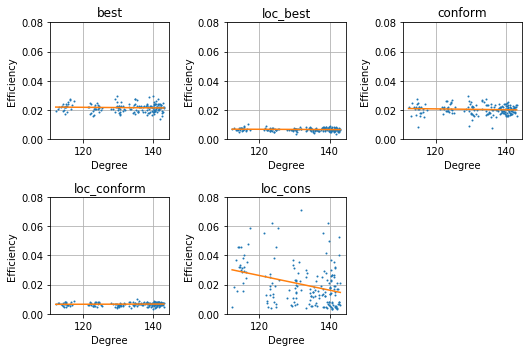

In [34]:
plt.figure(figsize=(3.0*15.0/6.0,2*15.0/6.0))
for j, strategy in enumerate(strategies):
    plt.subplot(2,3,1+j)
    df = df_eff[df_eff["strategy"] == strategy]
    r,p = spstats.pearsonr(df["degree"], df["eff"])
    m, b = np.polyfit(df["degree"], df["eff"], 1)
    #x, y = estimate_curve(df_strat["degree"], df_strat["eff"], 100, 5)
    x, y = line_points(m,b,df["degree"])
    plt.plot(df["degree"], df["eff"], '.', markersize=2)
    plt.plot(x, y)
    plt.title(strategy)
    print "%s r=%0.2f p=%0.4f m=%f, b=%f" % (strategy, r, p, m, b)
    xlabel("Degree")
    ylabel("Efficiency")
    ylim([0,0.08])
    plt.grid()
plt.tight_layout()
plt.savefig("fig-deg-eff.pdf", format="pdf")
plt.savefig("fig-deg-eff.png", format="png", dpi=300)


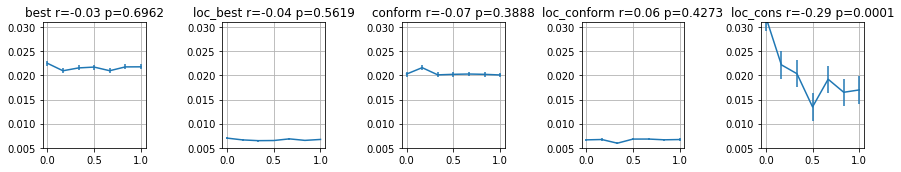

In [67]:
plt.figure(figsize=(5.0*15.0/6.0,15.0/6.0))
for j, strategy in enumerate(strategies):
    plt.subplot(1,5,1+j)
    df_strat = df_eff[df_eff["strategy"] == strategy]
    r,p = spstats.pearsonr(df_strat["rewire"], df_strat["eff"])
    mean = []
    serr = []
    std = []
    for rw in rs:
        df = df_strat[(df_strat["rewire"] - rw).abs() < 0.01]
        m = df["eff"].mean()
        s = df["eff"].std(ddof=1)
        se = s / sqrt(float(len(df["eff"])))
        mean.append(m)
        serr.append(se)
        std.append(s)
    m, b = np.polyfit(df_strat["degree"], df_strat["eff"], 1)
    #x, y = estimate_curve(df_strat["degree"], df_strat["eff"], 100, 5)
    x, y = line_points(m,b,df_strat["degree"])
    plt.errorbar(sorted(set(df_strat["rewire"])), mean, yerr=se)
    plt.title("%s r=%0.2f p=%0.4f" % (strategy, r, p))
    plt.legend()
    plt.grid()
    plt.ylim([0.005, 0.031])
plt.tight_layout()


In [ ]:
plt.plot(df_runs["degree"], df_runs["meanpath"], '.')

In [ ]:
for strategy in strategies:
    print "%s: %d" % (
        strategy,
        len(df_eff[(df_eff["eff"] == 0.005) & (df_eff["strategy"] == strategy)]))

In [77]:
df_eff.to_csv("all.csv")

In [ ]:
plot(df_runs["rewire"], df_runs["degree"], ".")

In [76]:
df_eff.head()

,converge,degree,eff,perf,rewire,strategy,trial
0,34,129.764,0.029412,0.710549,0.333333,best,1501934538-0
1,129,129.764,0.007752,0.716422,0.333333,loc_best,1501934538-0
2,41,129.764,0.024390,0.725142,0.333333,conform,1501934538-0
3,144,129.764,0.006944,0.737538,0.333333,loc_conform,1501934538-0
4,127,129.764,0.007874,0.739553,0.333333,loc_cons,1501934538-0


In [83]:
df_runs["meanpath"].mean()

1.7348790992389405

In [84]:
df_runs["meanpath"].std()

0.018503670848537608